<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:09:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


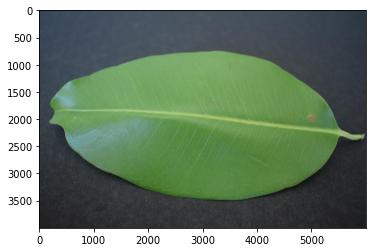

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

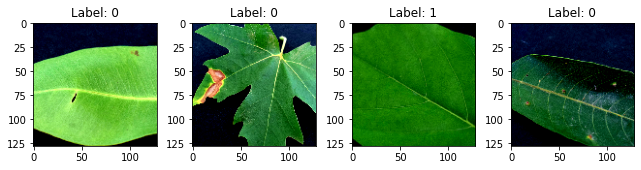

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:25] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2355134288646303 samples/sec                   batch loss = 0.38026729226112366 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2642790785719324 samples/sec                   batch loss = 0.5824319124221802 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2546208068296199 samples/sec                   batch loss = 0.5387026071548462 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2575892137009121 samples/sec                   batch loss = 0.7897211909294128 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2694533445771992 samples/sec                   batch loss = 0.43052181601524353 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2617878665357438 samples/sec                   batch loss = 0.8981891870498657 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2382133233197063 samples/sec                   batch loss = 0.8403345942497253 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2677894787749822 samples/sec                   batch loss = 0.5623692870140076 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.2646098547545275 samples/sec                   batch loss = 0.8118249773979187 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.266133695416092 samples/sec                   batch loss = 0.3912336826324463 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2711748430486376 samples/sec                   batch loss = 0.3943631052970886 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2668705423279354 samples/sec                   batch loss = 0.5346324443817139 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2630636227453622 samples/sec                   batch loss = 0.4947817027568817 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2726376119839549 samples/sec                   batch loss = 0.8462224006652832 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.263301770647832 samples/sec                   batch loss = 0.36006832122802734 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2707055805425873 samples/sec                   batch loss = 0.3507080674171448 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2630073325300337 samples/sec                   batch loss = 0.3797508776187897 | accuracy = 0.5735294117647058


Epoch[1] Batch[90] Speed: 1.2612414961076952 samples/sec                   batch loss = 0.49881431460380554 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2653003629933106 samples/sec                   batch loss = 0.27985909581184387 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2700080081312168 samples/sec                   batch loss = 0.5231512784957886 | accuracy = 0.6


Epoch[1] Batch[105] Speed: 1.2672315821738154 samples/sec                   batch loss = 2.21818470954895 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2700087772320343 samples/sec                   batch loss = 0.8480169773101807 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.2678194654974595 samples/sec                   batch loss = 0.46409669518470764 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.2750164514295055 samples/sec                   batch loss = 0.443203866481781 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.2651181253116661 samples/sec                   batch loss = 1.3132165670394897 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.2668640372685958 samples/sec                   batch loss = 0.8088808059692383 | accuracy = 0.6173076923076923


Epoch[1] Batch[135] Speed: 1.268744289041592 samples/sec                   batch loss = 0.32895344495773315 | accuracy = 0.6166666666666667


Epoch[1] Batch[140] Speed: 1.2701018453069632 samples/sec                   batch loss = 0.4536847174167633 | accuracy = 0.6196428571428572


Epoch[1] Batch[145] Speed: 1.2708618024325817 samples/sec                   batch loss = 0.8646292090415955 | accuracy = 0.6137931034482759


Epoch[1] Batch[150] Speed: 1.2710170035445896 samples/sec                   batch loss = 0.6869394779205322 | accuracy = 0.6166666666666667


Epoch[1] Batch[155] Speed: 1.2697936575921398 samples/sec                   batch loss = 0.4593007564544678 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2679975947883453 samples/sec                   batch loss = 0.22529414296150208 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2806991121022866 samples/sec                   batch loss = 0.7692223787307739 | accuracy = 0.6257575757575757


Epoch[1] Batch[170] Speed: 1.26695348769069 samples/sec                   batch loss = 0.18854720890522003 | accuracy = 0.6279411764705882


Epoch[1] Batch[175] Speed: 1.2675753017828482 samples/sec                   batch loss = 0.6997301578521729 | accuracy = 0.6328571428571429


Epoch[1] Batch[180] Speed: 1.268391400723965 samples/sec                   batch loss = 0.3214179277420044 | accuracy = 0.6375


Epoch[1] Batch[185] Speed: 1.2723230786894808 samples/sec                   batch loss = 0.2605316936969757 | accuracy = 0.6378378378378379


Epoch[1] Batch[190] Speed: 1.262649550586236 samples/sec                   batch loss = 0.9954119324684143 | accuracy = 0.6328947368421053


Epoch[1] Batch[195] Speed: 1.2662256229988353 samples/sec                   batch loss = 0.8306636214256287 | accuracy = 0.6307692307692307


Epoch[1] Batch[200] Speed: 1.2586829021191395 samples/sec                   batch loss = 1.4986851215362549 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.257402593587112 samples/sec                   batch loss = 0.45767611265182495 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.263224438820314 samples/sec                   batch loss = 0.7078933715820312 | accuracy = 0.6321428571428571


Epoch[1] Batch[215] Speed: 1.271611200160562 samples/sec                   batch loss = 0.6916895508766174 | accuracy = 0.6302325581395349


Epoch[1] Batch[220] Speed: 1.270219353617565 samples/sec                   batch loss = 0.35707783699035645 | accuracy = 0.6306818181818182


Epoch[1] Batch[225] Speed: 1.2643756919234586 samples/sec                   batch loss = 0.8421955704689026 | accuracy = 0.6277777777777778


Epoch[1] Batch[230] Speed: 1.2653725092706933 samples/sec                   batch loss = 0.34548714756965637 | accuracy = 0.6304347826086957


Epoch[1] Batch[235] Speed: 1.2710224921189968 samples/sec                   batch loss = 0.4852178990840912 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2670211339908386 samples/sec                   batch loss = 0.8553553819656372 | accuracy = 0.6385416666666667


Epoch[1] Batch[245] Speed: 1.2554012349720634 samples/sec                   batch loss = 0.9243142008781433 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2552814743729697 samples/sec                   batch loss = 0.4946594536304474 | accuracy = 0.639


Epoch[1] Batch[255] Speed: 1.260838282456304 samples/sec                   batch loss = 0.5121726393699646 | accuracy = 0.638235294117647


Epoch[1] Batch[260] Speed: 1.261214474439217 samples/sec                   batch loss = 0.4959096312522888 | accuracy = 0.6413461538461539


Epoch[1] Batch[265] Speed: 1.2614982122927458 samples/sec                   batch loss = 0.42608919739723206 | accuracy = 0.6424528301886793


Epoch[1] Batch[270] Speed: 1.2610348334872181 samples/sec                   batch loss = 0.48893558979034424 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.259561341656927 samples/sec                   batch loss = 0.704493522644043 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.2677725220550058 samples/sec                   batch loss = 0.3086605966091156 | accuracy = 0.6473214285714286


Epoch[1] Batch[285] Speed: 1.2694201109058028 samples/sec                   batch loss = 0.48890671133995056 | accuracy = 0.6508771929824562


Epoch[1] Batch[290] Speed: 1.2663931719362673 samples/sec                   batch loss = 0.35023319721221924 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.2621857055491144 samples/sec                   batch loss = 0.3780768811702728 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.265497925951259 samples/sec                   batch loss = 0.37516796588897705 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2609026239017975 samples/sec                   batch loss = 0.6517111659049988 | accuracy = 0.6549180327868852


Epoch[1] Batch[310] Speed: 1.2624911609072693 samples/sec                   batch loss = 0.2088818997144699 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2618838147677391 samples/sec                   batch loss = 0.916545033454895 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.270197812005119 samples/sec                   batch loss = 0.5351700782775879 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.2568023918865712 samples/sec                   batch loss = 0.6887357234954834 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.2595948176565337 samples/sec                   batch loss = 0.6356270909309387 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2588243750640584 samples/sec                   batch loss = 0.45289281010627747 | accuracy = 0.6574626865671642


Epoch[1] Batch[340] Speed: 1.266813051396746 samples/sec                   batch loss = 0.5460439324378967 | accuracy = 0.6580882352941176


Epoch[1] Batch[345] Speed: 1.2547624941757543 samples/sec                   batch loss = 0.670907199382782 | accuracy = 0.6608695652173913


Epoch[1] Batch[350] Speed: 1.2577604251006076 samples/sec                   batch loss = 0.6600490212440491 | accuracy = 0.6614285714285715


Epoch[1] Batch[355] Speed: 1.26067570506234 samples/sec                   batch loss = 0.60371333360672 | accuracy = 0.6591549295774648


Epoch[1] Batch[360] Speed: 1.2564036106254866 samples/sec                   batch loss = 0.6084299087524414 | accuracy = 0.6590277777777778


Epoch[1] Batch[365] Speed: 1.2590659347462978 samples/sec                   batch loss = 0.726413369178772 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.270989753956006 samples/sec                   batch loss = 0.39870086312294006 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.263943999948168 samples/sec                   batch loss = 0.4442709684371948 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.2665868690220183 samples/sec                   batch loss = 0.6391493082046509 | accuracy = 0.6598684210526315


Epoch[1] Batch[385] Speed: 1.2655873744933228 samples/sec                   batch loss = 0.4766751825809479 | accuracy = 0.6584415584415585


Epoch[1] Batch[390] Speed: 1.2556733408272098 samples/sec                   batch loss = 0.21111099421977997 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.2567866692585639 samples/sec                   batch loss = 0.47658783197402954 | accuracy = 0.6632911392405063


Epoch[1] Batch[400] Speed: 1.2573201402227026 samples/sec                   batch loss = 0.5392531752586365 | accuracy = 0.665625


Epoch[1] Batch[405] Speed: 1.2609651712179555 samples/sec                   batch loss = 0.3179352879524231 | accuracy = 0.6666666666666666


Epoch[1] Batch[410] Speed: 1.25938273850403 samples/sec                   batch loss = 0.5691152215003967 | accuracy = 0.6658536585365854


Epoch[1] Batch[415] Speed: 1.2579228173029529 samples/sec                   batch loss = 1.4907350540161133 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.2569669852810064 samples/sec                   batch loss = 0.34822309017181396 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2584313892567631 samples/sec                   batch loss = 0.9819474220275879 | accuracy = 0.668235294117647


Epoch[1] Batch[430] Speed: 1.2573470895041685 samples/sec                   batch loss = 0.7368205785751343 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2575481148189536 samples/sec                   batch loss = 0.48945337533950806 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.2594388951792044 samples/sec                   batch loss = 0.5759971141815186 | accuracy = 0.6681818181818182


Epoch[1] Batch[445] Speed: 1.2616002829220834 samples/sec                   batch loss = 0.5515992045402527 | accuracy = 0.6685393258426966


Epoch[1] Batch[450] Speed: 1.2569227253827395 samples/sec                   batch loss = 0.6288596987724304 | accuracy = 0.6683333333333333


Epoch[1] Batch[455] Speed: 1.2582129077018183 samples/sec                   batch loss = 0.47379401326179504 | accuracy = 0.6681318681318681


Epoch[1] Batch[460] Speed: 1.2547056277276427 samples/sec                   batch loss = 1.042392611503601 | accuracy = 0.6690217391304348


Epoch[1] Batch[465] Speed: 1.2653268920172 samples/sec                   batch loss = 0.49058589339256287 | accuracy = 0.6693548387096774


Epoch[1] Batch[470] Speed: 1.2577441127545546 samples/sec                   batch loss = 0.6928284168243408 | accuracy = 0.6696808510638298


Epoch[1] Batch[475] Speed: 1.2563231697545794 samples/sec                   batch loss = 0.8072658777236938 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.266020667632614 samples/sec                   batch loss = 0.44404101371765137 | accuracy = 0.66875


Epoch[1] Batch[485] Speed: 1.2596568569814965 samples/sec                   batch loss = 0.2695637047290802 | accuracy = 0.6695876288659793


Epoch[1] Batch[490] Speed: 1.2608496530735342 samples/sec                   batch loss = 0.4107350707054138 | accuracy = 0.6693877551020408


Epoch[1] Batch[495] Speed: 1.2607057351415865 samples/sec                   batch loss = 0.48385903239250183 | accuracy = 0.6691919191919192


Epoch[1] Batch[500] Speed: 1.265309905679552 samples/sec                   batch loss = 0.8718542456626892 | accuracy = 0.67


Epoch[1] Batch[505] Speed: 1.256978851230373 samples/sec                   batch loss = 0.4319307208061218 | accuracy = 0.6702970297029703


Epoch[1] Batch[510] Speed: 1.2629022772220362 samples/sec                   batch loss = 0.497996985912323 | accuracy = 0.6691176470588235


Epoch[1] Batch[515] Speed: 1.2598973170998389 samples/sec                   batch loss = 1.282486081123352 | accuracy = 0.6679611650485436


Epoch[1] Batch[520] Speed: 1.2588261696514476 samples/sec                   batch loss = 0.33378568291664124 | accuracy = 0.66875


Epoch[1] Batch[525] Speed: 1.2599940189168652 samples/sec                   batch loss = 0.7940374612808228 | accuracy = 0.67


Epoch[1] Batch[530] Speed: 1.2628214773383406 samples/sec                   batch loss = 1.1889569759368896 | accuracy = 0.6688679245283019


Epoch[1] Batch[535] Speed: 1.2573405876487083 samples/sec                   batch loss = 2.637568473815918 | accuracy = 0.6682242990654206


Epoch[1] Batch[540] Speed: 1.2604288873930185 samples/sec                   batch loss = 0.3757001459598541 | accuracy = 0.6699074074074074


Epoch[1] Batch[545] Speed: 1.2634594123125498 samples/sec                   batch loss = 0.9133853316307068 | accuracy = 0.6692660550458716


Epoch[1] Batch[550] Speed: 1.263329642864915 samples/sec                   batch loss = 0.8919397592544556 | accuracy = 0.6704545454545454


Epoch[1] Batch[555] Speed: 1.2644095196142233 samples/sec                   batch loss = 0.9813088774681091 | accuracy = 0.6702702702702703


Epoch[1] Batch[560] Speed: 1.2669888886724028 samples/sec                   batch loss = 0.5374254584312439 | accuracy = 0.6696428571428571


Epoch[1] Batch[565] Speed: 1.268441842421889 samples/sec                   batch loss = 1.0699397325515747 | accuracy = 0.6690265486725664


Epoch[1] Batch[570] Speed: 1.2649565406277894 samples/sec                   batch loss = 0.5896645784378052 | accuracy = 0.6684210526315789


Epoch[1] Batch[575] Speed: 1.2657210458250454 samples/sec                   batch loss = 0.8644183874130249 | accuracy = 0.6669565217391304


Epoch[1] Batch[580] Speed: 1.257944699132624 samples/sec                   batch loss = 1.3139814138412476 | accuracy = 0.6681034482758621


Epoch[1] Batch[585] Speed: 1.2576583148944873 samples/sec                   batch loss = 0.2699384093284607 | accuracy = 0.6692307692307692


Epoch[1] Batch[590] Speed: 1.262691743861946 samples/sec                   batch loss = 0.5175533890724182 | accuracy = 0.6682203389830509


Epoch[1] Batch[595] Speed: 1.2625053164959317 samples/sec                   batch loss = 0.36539989709854126 | accuracy = 0.6680672268907563


Epoch[1] Batch[600] Speed: 1.2613139388544647 samples/sec                   batch loss = 0.5781440734863281 | accuracy = 0.6683333333333333


Epoch[1] Batch[605] Speed: 1.2596227156821798 samples/sec                   batch loss = 0.6711263060569763 | accuracy = 0.6681818181818182


Epoch[1] Batch[610] Speed: 1.2557587740682752 samples/sec                   batch loss = 0.4267726540565491 | accuracy = 0.6688524590163935


Epoch[1] Batch[615] Speed: 1.26663563724874 samples/sec                   batch loss = 0.3390968441963196 | accuracy = 0.6695121951219513


Epoch[1] Batch[620] Speed: 1.2648093952182573 samples/sec                   batch loss = 0.7334173321723938 | accuracy = 0.6693548387096774


Epoch[1] Batch[625] Speed: 1.2652007459437669 samples/sec                   batch loss = 0.39746716618537903 | accuracy = 0.6704


Epoch[1] Batch[630] Speed: 1.2639541887484136 samples/sec                   batch loss = 0.31048399209976196 | accuracy = 0.6726190476190477


Epoch[1] Batch[635] Speed: 1.267085533856283 samples/sec                   batch loss = 0.6303699016571045 | accuracy = 0.6728346456692913


Epoch[1] Batch[640] Speed: 1.2597364010927437 samples/sec                   batch loss = 0.2859976589679718 | accuracy = 0.6734375


Epoch[1] Batch[645] Speed: 1.259128583464433 samples/sec                   batch loss = 0.5636510848999023 | accuracy = 0.6748062015503876


Epoch[1] Batch[650] Speed: 1.2641694298275192 samples/sec                   batch loss = 0.34768372774124146 | accuracy = 0.6757692307692308


Epoch[1] Batch[655] Speed: 1.2683199644992915 samples/sec                   batch loss = 1.3937633037567139 | accuracy = 0.6751908396946565


Epoch[1] Batch[660] Speed: 1.2634004228951987 samples/sec                   batch loss = 0.6017071604728699 | accuracy = 0.6753787878787879


Epoch[1] Batch[665] Speed: 1.2617556972496156 samples/sec                   batch loss = 0.7617200613021851 | accuracy = 0.675187969924812


Epoch[1] Batch[670] Speed: 1.2655683763601178 samples/sec                   batch loss = 0.27375656366348267 | accuracy = 0.675


Epoch[1] Batch[675] Speed: 1.269623093962856 samples/sec                   batch loss = 0.6604744791984558 | accuracy = 0.6755555555555556


Epoch[1] Batch[680] Speed: 1.2681457705611652 samples/sec                   batch loss = 0.31274235248565674 | accuracy = 0.6764705882352942


Epoch[1] Batch[685] Speed: 1.2614151260951527 samples/sec                   batch loss = 0.4758322536945343 | accuracy = 0.6762773722627737


Epoch[1] Batch[690] Speed: 1.2669880275439667 samples/sec                   batch loss = 0.5639801621437073 | accuracy = 0.6753623188405797


Epoch[1] Batch[695] Speed: 1.2667164477732518 samples/sec                   batch loss = 0.7017415165901184 | accuracy = 0.6758992805755396


Epoch[1] Batch[700] Speed: 1.2733473546221032 samples/sec                   batch loss = 0.6793292760848999 | accuracy = 0.675


Epoch[1] Batch[705] Speed: 1.270480603819238 samples/sec                   batch loss = 0.39143800735473633 | accuracy = 0.674822695035461


Epoch[1] Batch[710] Speed: 1.2660859212786482 samples/sec                   batch loss = 0.3289593756198883 | accuracy = 0.676056338028169


Epoch[1] Batch[715] Speed: 1.265375467825394 samples/sec                   batch loss = 0.6111099720001221 | accuracy = 0.6765734265734266


Epoch[1] Batch[720] Speed: 1.2583480458729723 samples/sec                   batch loss = 0.6354755759239197 | accuracy = 0.6770833333333334


Epoch[1] Batch[725] Speed: 1.2711845708653733 samples/sec                   batch loss = 0.41076481342315674 | accuracy = 0.6762068965517242


Epoch[1] Batch[730] Speed: 1.2712081686632164 samples/sec                   batch loss = 1.1627241373062134 | accuracy = 0.6753424657534246


Epoch[1] Batch[735] Speed: 1.2659860849720248 samples/sec                   batch loss = 0.45913493633270264 | accuracy = 0.6758503401360544


Epoch[1] Batch[740] Speed: 1.2665318897405973 samples/sec                   batch loss = 0.5354204773902893 | accuracy = 0.6746621621621621


Epoch[1] Batch[745] Speed: 1.269171393879022 samples/sec                   batch loss = 0.4398685395717621 | accuracy = 0.6741610738255034


Epoch[1] Batch[750] Speed: 1.2762075588670447 samples/sec                   batch loss = 0.831632673740387 | accuracy = 0.6743333333333333


Epoch[1] Batch[755] Speed: 1.2731257890060776 samples/sec                   batch loss = 0.7547414302825928 | accuracy = 0.6745033112582781


Epoch[1] Batch[760] Speed: 1.2716978520581994 samples/sec                   batch loss = 0.9369515180587769 | accuracy = 0.6753289473684211


Epoch[1] Batch[765] Speed: 1.2730244530303123 samples/sec                   batch loss = 0.21846865117549896 | accuracy = 0.6761437908496732


Epoch[1] Batch[770] Speed: 1.26569679192958 samples/sec                   batch loss = 0.320198655128479 | accuracy = 0.6772727272727272


Epoch[1] Batch[775] Speed: 1.2633797779004385 samples/sec                   batch loss = 0.5202317237854004 | accuracy = 0.677741935483871


Epoch[1] Batch[780] Speed: 1.265242346558818 samples/sec                   batch loss = 0.3210242986679077 | accuracy = 0.6782051282051282


Epoch[1] Batch[785] Speed: 1.2630748433542356 samples/sec                   batch loss = 0.49675676226615906 | accuracy = 0.6789808917197452


[Epoch 1] training: accuracy=0.679251269035533
[Epoch 1] time cost: 649.3867456912994
[Epoch 1] validation: validation accuracy=0.7333333333333333


Epoch[2] Batch[5] Speed: 1.2691015017747298 samples/sec                   batch loss = 1.1598783731460571 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.269864010419154 samples/sec                   batch loss = 1.1337611675262451 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2781932764562298 samples/sec                   batch loss = 0.2855475842952728 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2698702579732777 samples/sec                   batch loss = 0.6964542269706726 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2767235450831633 samples/sec                   batch loss = 0.30861231684684753 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2763329965222903 samples/sec                   batch loss = 0.3098088204860687 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2672535018974567 samples/sec                   batch loss = 0.19257918000221252 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2712824352053635 samples/sec                   batch loss = 0.21253380179405212 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2735088668535801 samples/sec                   batch loss = 0.6619154810905457 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2770716561412563 samples/sec                   batch loss = 0.5750054717063904 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2722994394810887 samples/sec                   batch loss = 0.4183919131755829 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.268812126714107 samples/sec                   batch loss = 0.5160022377967834 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2663692746251383 samples/sec                   batch loss = 0.2515972852706909 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2705509365696006 samples/sec                   batch loss = 0.8211174607276917 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2657411944529005 samples/sec                   batch loss = 0.5152919888496399 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2657594338113738 samples/sec                   batch loss = 0.528611421585083 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2734268007614808 samples/sec                   batch loss = 0.7799828052520752 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2699187026331797 samples/sec                   batch loss = 0.2739638090133667 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2645834511068448 samples/sec                   batch loss = 0.3350922167301178 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2706594817302923 samples/sec                   batch loss = 0.29243069887161255 | accuracy = 0.7575


Epoch[2] Batch[105] Speed: 1.2691758103969404 samples/sec                   batch loss = 0.4665285348892212 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.2678501243160276 samples/sec                   batch loss = 0.37415018677711487 | accuracy = 0.7613636363636364


Epoch[2] Batch[115] Speed: 1.272907004631252 samples/sec                   batch loss = 0.37124696373939514 | accuracy = 0.7630434782608696


Epoch[2] Batch[120] Speed: 1.2682685737495447 samples/sec                   batch loss = 0.39303770661354065 | accuracy = 0.7625


Epoch[2] Batch[125] Speed: 1.2749741087151265 samples/sec                   batch loss = 0.3115309476852417 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.2688560763485006 samples/sec                   batch loss = 0.7576146125793457 | accuracy = 0.7634615384615384


Epoch[2] Batch[135] Speed: 1.2726751656231476 samples/sec                   batch loss = 0.37956470251083374 | accuracy = 0.7648148148148148


Epoch[2] Batch[140] Speed: 1.272009568797568 samples/sec                   batch loss = 0.8707628846168518 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2684956449280145 samples/sec                   batch loss = 0.4878436326980591 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.2651739359878644 samples/sec                   batch loss = 0.6911186575889587 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.2687038969284559 samples/sec                   batch loss = 0.29881104826927185 | accuracy = 0.7612903225806451


Epoch[2] Batch[160] Speed: 1.2682718334868288 samples/sec                   batch loss = 0.5665297508239746 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.2695422003651864 samples/sec                   batch loss = 0.45244622230529785 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2726786411362492 samples/sec                   batch loss = 0.2781766951084137 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2767458915710668 samples/sec                   batch loss = 0.2617586553096771 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2698349841278347 samples/sec                   batch loss = 0.2907373905181885 | accuracy = 0.7597222222222222


Epoch[2] Batch[185] Speed: 1.2663232987353836 samples/sec                   batch loss = 0.48973000049591064 | accuracy = 0.7567567567567568


Epoch[2] Batch[190] Speed: 1.2679757451462783 samples/sec                   batch loss = 0.23313283920288086 | accuracy = 0.7631578947368421


Epoch[2] Batch[195] Speed: 1.2666912949900087 samples/sec                   batch loss = 0.20407749712467194 | accuracy = 0.7628205128205128


Epoch[2] Batch[200] Speed: 1.2695365324354198 samples/sec                   batch loss = 0.7225360870361328 | accuracy = 0.76125


Epoch[2] Batch[205] Speed: 1.2640012307598654 samples/sec                   batch loss = 0.3363650441169739 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.2685894505861772 samples/sec                   batch loss = 0.5446654558181763 | accuracy = 0.7595238095238095


Epoch[2] Batch[215] Speed: 1.2659509310546662 samples/sec                   batch loss = 0.5562507510185242 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2682542886278885 samples/sec                   batch loss = 0.4895348846912384 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2651652540037097 samples/sec                   batch loss = 0.9695656299591064 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2627838376287277 samples/sec                   batch loss = 0.3849252462387085 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.2675623730196812 samples/sec                   batch loss = 0.27029335498809814 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2633958562022962 samples/sec                   batch loss = 0.49750712513923645 | accuracy = 0.7614583333333333


Epoch[2] Batch[245] Speed: 1.2670777825601076 samples/sec                   batch loss = 0.5847476124763489 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2698737181835522 samples/sec                   batch loss = 0.47710251808166504 | accuracy = 0.761


Epoch[2] Batch[255] Speed: 1.2691692816421871 samples/sec                   batch loss = 1.1065375804901123 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2644423008498868 samples/sec                   batch loss = 0.16391173005104065 | accuracy = 0.7625


Epoch[2] Batch[265] Speed: 1.2670558689148381 samples/sec                   batch loss = 0.7107880711555481 | accuracy = 0.7632075471698113


Epoch[2] Batch[270] Speed: 1.2670372094214033 samples/sec                   batch loss = 0.4842228293418884 | accuracy = 0.7638888888888888


Epoch[2] Batch[275] Speed: 1.2680875887515723 samples/sec                   batch loss = 0.45430001616477966 | accuracy = 0.7618181818181818


Epoch[2] Batch[280] Speed: 1.2689512790095758 samples/sec                   batch loss = 0.3894483149051666 | accuracy = 0.7625


Epoch[2] Batch[285] Speed: 1.2682249524072153 samples/sec                   batch loss = 0.5750380158424377 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2697334025571436 samples/sec                   batch loss = 0.3466967046260834 | accuracy = 0.7637931034482759


Epoch[2] Batch[295] Speed: 1.271380989033315 samples/sec                   batch loss = 0.8310827016830444 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.26083496606491 samples/sec                   batch loss = 0.21998412907123566 | accuracy = 0.7616666666666667


Epoch[2] Batch[305] Speed: 1.2729917082468345 samples/sec                   batch loss = 0.6855232119560242 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.270543912566015 samples/sec                   batch loss = 0.3318864107131958 | accuracy = 0.7612903225806451


Epoch[2] Batch[315] Speed: 1.269970227200403 samples/sec                   batch loss = 0.17426082491874695 | accuracy = 0.7626984126984127


Epoch[2] Batch[320] Speed: 1.2682130649133496 samples/sec                   batch loss = 0.21832643449306488 | accuracy = 0.76015625


Epoch[2] Batch[325] Speed: 1.2673604312459963 samples/sec                   batch loss = 0.4203457236289978 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2635652264879689 samples/sec                   batch loss = 0.3398111164569855 | accuracy = 0.7606060606060606


Epoch[2] Batch[335] Speed: 1.2587023551243013 samples/sec                   batch loss = 0.30090850591659546 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2665301687270951 samples/sec                   batch loss = 0.6531777381896973 | accuracy = 0.763235294117647


Epoch[2] Batch[345] Speed: 1.272141320592622 samples/sec                   batch loss = 1.0576249361038208 | accuracy = 0.7608695652173914


Epoch[2] Batch[350] Speed: 1.2760361413930543 samples/sec                   batch loss = 0.1821126788854599 | accuracy = 0.7607142857142857


Epoch[2] Batch[355] Speed: 1.2745592601649864 samples/sec                   batch loss = 0.689284086227417 | accuracy = 0.7584507042253521


Epoch[2] Batch[360] Speed: 1.2712696233666911 samples/sec                   batch loss = 0.8137330412864685 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.282906781432723 samples/sec                   batch loss = 0.4190549850463867 | accuracy = 0.7589041095890411


Epoch[2] Batch[370] Speed: 1.2758184901034277 samples/sec                   batch loss = 0.6717731952667236 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.2711906387868557 samples/sec                   batch loss = 0.4016670882701874 | accuracy = 0.758


Epoch[2] Batch[380] Speed: 1.2732589317087557 samples/sec                   batch loss = 0.3311813473701477 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2719531534244455 samples/sec                   batch loss = 0.1544794887304306 | accuracy = 0.759090909090909


Epoch[2] Batch[390] Speed: 1.2719514176461673 samples/sec                   batch loss = 0.2648339569568634 | accuracy = 0.7589743589743589


Epoch[2] Batch[395] Speed: 1.251969941168543 samples/sec                   batch loss = 0.7413036227226257 | accuracy = 0.760759493670886


Epoch[2] Batch[400] Speed: 1.2724083801161314 samples/sec                   batch loss = 0.27198246121406555 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.2689203749669293 samples/sec                   batch loss = 0.40024447441101074 | accuracy = 0.7611111111111111


Epoch[2] Batch[410] Speed: 1.267299258174549 samples/sec                   batch loss = 0.5747289061546326 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.270054155829104 samples/sec                   batch loss = 0.324156254529953 | accuracy = 0.7596385542168674


Epoch[2] Batch[420] Speed: 1.2745733971840016 samples/sec                   batch loss = 0.7437927722930908 | accuracy = 0.7607142857142857


Epoch[2] Batch[425] Speed: 1.2734951401039156 samples/sec                   batch loss = 0.2374171018600464 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2735369012757067 samples/sec                   batch loss = 0.5055403113365173 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.1048182216468487 samples/sec                   batch loss = 0.4146435856819153 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 0.831332914195378 samples/sec                   batch loss = 0.36570417881011963 | accuracy = 0.7619318181818182


Epoch[2] Batch[445] Speed: 0.7482635220230694 samples/sec                   batch loss = 0.5854547023773193 | accuracy = 0.7584269662921348


Epoch[2] Batch[450] Speed: 1.1916254180792043 samples/sec                   batch loss = 0.8212769031524658 | accuracy = 0.7594444444444445


Epoch[2] Batch[455] Speed: 1.2558425268450943 samples/sec                   batch loss = 0.27267059683799744 | accuracy = 0.7598901098901099


Epoch[2] Batch[460] Speed: 1.2610450702243559 samples/sec                   batch loss = 0.3214928209781647 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.261805327838029 samples/sec                   batch loss = 0.4503697156906128 | accuracy = 0.7580645161290323


Epoch[2] Batch[470] Speed: 1.2663633482315486 samples/sec                   batch loss = 0.4040542244911194 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2683405794964957 samples/sec                   batch loss = 0.2019626498222351 | accuracy = 0.758421052631579


Epoch[2] Batch[480] Speed: 1.2650323677327928 samples/sec                   batch loss = 0.6869275569915771 | accuracy = 0.7578125


Epoch[2] Batch[485] Speed: 1.2644205735618843 samples/sec                   batch loss = 0.6589429974555969 | accuracy = 0.7577319587628866


Epoch[2] Batch[490] Speed: 1.267389248776536 samples/sec                   batch loss = 0.7938380241394043 | accuracy = 0.7571428571428571


Epoch[2] Batch[495] Speed: 1.2601796106510508 samples/sec                   batch loss = 0.47492340207099915 | accuracy = 0.7575757575757576


Epoch[2] Batch[500] Speed: 1.2731743857640645 samples/sec                   batch loss = 0.6360726952552795 | accuracy = 0.757


Epoch[2] Batch[505] Speed: 1.2680325749497219 samples/sec                   batch loss = 0.5417644381523132 | accuracy = 0.7554455445544555


Epoch[2] Batch[510] Speed: 1.2631796420557737 samples/sec                   batch loss = 0.11589465290307999 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2633308795446796 samples/sec                   batch loss = 0.9128809571266174 | accuracy = 0.7553398058252427


Epoch[2] Batch[520] Speed: 1.2580829872656076 samples/sec                   batch loss = 0.3604292869567871 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.269751661054765 samples/sec                   batch loss = 0.41293296217918396 | accuracy = 0.7566666666666667


Epoch[2] Batch[530] Speed: 1.2676236672726027 samples/sec                   batch loss = 0.35607394576072693 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.268593863054874 samples/sec                   batch loss = 0.1409662663936615 | accuracy = 0.7570093457943925


Epoch[2] Batch[540] Speed: 1.2694977228862212 samples/sec                   batch loss = 0.41473817825317383 | accuracy = 0.7578703703703704


Epoch[2] Batch[545] Speed: 1.2640743718530871 samples/sec                   batch loss = 0.3565739095211029 | accuracy = 0.7582568807339449


Epoch[2] Batch[550] Speed: 1.2707629440691992 samples/sec                   batch loss = 0.5025738477706909 | accuracy = 0.7586363636363637


Epoch[2] Batch[555] Speed: 1.2620263879497553 samples/sec                   batch loss = 0.3047950267791748 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2647241561842233 samples/sec                   batch loss = 0.7071742415428162 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2628282261093544 samples/sec                   batch loss = 0.2895384430885315 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.2688195154135349 samples/sec                   batch loss = 1.4593759775161743 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.2631464507487267 samples/sec                   batch loss = 0.5452296733856201 | accuracy = 0.7573913043478261


Epoch[2] Batch[580] Speed: 1.2631223905192581 samples/sec                   batch loss = 0.47107478976249695 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.2697760706033936 samples/sec                   batch loss = 0.8755509257316589 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.2653022715190438 samples/sec                   batch loss = 0.7031502723693848 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.2666298039885981 samples/sec                   batch loss = 0.47974640130996704 | accuracy = 0.7579831932773109


Epoch[2] Batch[600] Speed: 1.2656253724709319 samples/sec                   batch loss = 0.6017946600914001 | accuracy = 0.7579166666666667


Epoch[2] Batch[605] Speed: 1.2666505553387497 samples/sec                   batch loss = 0.34811291098594666 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2560820029731707 samples/sec                   batch loss = 0.49989861249923706 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2716649827068827 samples/sec                   batch loss = 0.49303898215293884 | accuracy = 0.758130081300813


Epoch[2] Batch[620] Speed: 1.2682026156068174 samples/sec                   batch loss = 0.5578375458717346 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.2406336948430914 samples/sec                   batch loss = 0.33036985993385315 | accuracy = 0.7592


Epoch[2] Batch[630] Speed: 1.2590701867245264 samples/sec                   batch loss = 0.33897748589515686 | accuracy = 0.7607142857142857


Epoch[2] Batch[635] Speed: 1.2700916533031308 samples/sec                   batch loss = 0.3941904604434967 | accuracy = 0.7614173228346457


Epoch[2] Batch[640] Speed: 1.2488523427720204 samples/sec                   batch loss = 1.015648603439331 | accuracy = 0.76015625


Epoch[2] Batch[645] Speed: 1.270368818673674 samples/sec                   batch loss = 0.3628864884376526 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.2657754772418355 samples/sec                   batch loss = 0.37656068801879883 | accuracy = 0.7615384615384615


Epoch[2] Batch[655] Speed: 1.2731284940958922 samples/sec                   batch loss = 0.6659333109855652 | accuracy = 0.7599236641221374


Epoch[2] Batch[660] Speed: 1.2652851904185576 samples/sec                   batch loss = 0.215547114610672 | accuracy = 0.759090909090909


Epoch[2] Batch[665] Speed: 1.2605241555152875 samples/sec                   batch loss = 0.9472436308860779 | accuracy = 0.7590225563909775


Epoch[2] Batch[670] Speed: 1.2594339789066105 samples/sec                   batch loss = 0.3803308606147766 | accuracy = 0.758955223880597


Epoch[2] Batch[675] Speed: 1.2634206879932526 samples/sec                   batch loss = 0.5483027696609497 | accuracy = 0.7585185185185185


Epoch[2] Batch[680] Speed: 1.2611335111791577 samples/sec                   batch loss = 0.6371690034866333 | accuracy = 0.7595588235294117


Epoch[2] Batch[685] Speed: 1.2635793110060431 samples/sec                   batch loss = 0.29216936230659485 | accuracy = 0.7598540145985402


Epoch[2] Batch[690] Speed: 1.2581277063045657 samples/sec                   batch loss = 0.2521441876888275 | accuracy = 0.7597826086956522


Epoch[2] Batch[695] Speed: 1.2661701972866557 samples/sec                   batch loss = 0.37787768244743347 | accuracy = 0.7600719424460431


Epoch[2] Batch[700] Speed: 1.258086949583735 samples/sec                   batch loss = 0.5091113448143005 | accuracy = 0.7607142857142857


Epoch[2] Batch[705] Speed: 1.2539781734219695 samples/sec                   batch loss = 0.5501335263252258 | accuracy = 0.7606382978723404


Epoch[2] Batch[710] Speed: 1.2499687828469268 samples/sec                   batch loss = 0.3430243134498596 | accuracy = 0.7602112676056338


Epoch[2] Batch[715] Speed: 1.2571674180450096 samples/sec                   batch loss = 0.41602158546447754 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.261415600300384 samples/sec                   batch loss = 0.8402113914489746 | accuracy = 0.7597222222222222


Epoch[2] Batch[725] Speed: 1.2508305275063984 samples/sec                   batch loss = 0.6389350891113281 | accuracy = 0.7596551724137931


Epoch[2] Batch[730] Speed: 1.2580943082407603 samples/sec                   batch loss = 0.6310384273529053 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2491988127514775 samples/sec                   batch loss = 0.23738916218280792 | accuracy = 0.7615646258503401


Epoch[2] Batch[740] Speed: 1.2543402477291963 samples/sec                   batch loss = 0.13146260380744934 | accuracy = 0.7614864864864865


Epoch[2] Batch[745] Speed: 1.247685004085768 samples/sec                   batch loss = 0.43964719772338867 | accuracy = 0.7610738255033557


Epoch[2] Batch[750] Speed: 1.2578704737732846 samples/sec                   batch loss = 0.37212738394737244 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.2516156764990007 samples/sec                   batch loss = 0.5103518962860107 | accuracy = 0.7609271523178808


Epoch[2] Batch[760] Speed: 1.2600395363576846 samples/sec                   batch loss = 1.958283543586731 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2564154659405107 samples/sec                   batch loss = 0.5619479417800903 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.2541264654802715 samples/sec                   batch loss = 0.7275298833847046 | accuracy = 0.7584415584415585


Epoch[2] Batch[775] Speed: 1.2576229620391206 samples/sec                   batch loss = 0.13107025623321533 | accuracy = 0.7587096774193548


Epoch[2] Batch[780] Speed: 1.2468465822485282 samples/sec                   batch loss = 0.4575902223587036 | accuracy = 0.7573717948717948


Epoch[2] Batch[785] Speed: 1.2524319164544533 samples/sec                   batch loss = 0.3141842484474182 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.7572969543147208
[Epoch 2] time cost: 650.1554775238037
[Epoch 2] validation: validation accuracy=0.7711111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)